In [10]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [11]:
# Step 2: Load and Prepare Dataset
df = pd.read_csv("AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df = df[['Date', 'Close']]
df.set_index('Date', inplace=True)
df = df.sort_index()

In [12]:
# Step 3: Normalize the 'Close' prices
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

In [13]:
# Step 4: Create sequences (60-day window)
def create_sequences(data, window_size=60):
    x, y = [], []
    for i in range(window_size, len(data)):
        x.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(x), np.array(y)

x, y = create_sequences(scaled_data, window_size=60)
x = x.reshape((x.shape[0], x.shape[1], 1))  # [samples, timesteps, features]

In [14]:
# Step 5: Split into training and testing sets
train_size = int(len(x) * 0.8)
x_train, y_train = x[:train_size], y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

In [15]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [16]:
# Create DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [17]:
# Step 6: Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

In [18]:
# Step 7: Train the model
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        output = model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/20, Loss: 0.0000
Epoch 2/20, Loss: 0.0000
Epoch 3/20, Loss: 0.0000
Epoch 4/20, Loss: 0.0000
Epoch 5/20, Loss: 0.0000
Epoch 6/20, Loss: 0.0000
Epoch 7/20, Loss: 0.0000
Epoch 8/20, Loss: 0.0000
Epoch 9/20, Loss: 0.0000
Epoch 10/20, Loss: 0.0000
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000


In [19]:
# Step 8: Make Predictions
model.eval()
with torch.no_grad():
    predictions = model(x_test_tensor).numpy()
    predictions = scaler.inverse_transform(predictions)
    actual = scaler.inverse_transform(y_test_tensor.reshape(-1, 1).numpy())

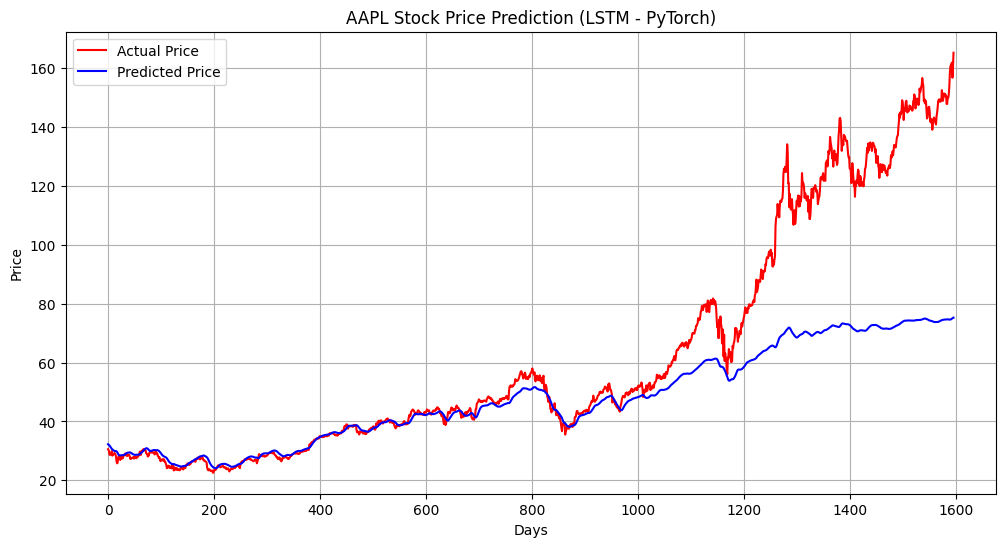

In [20]:
# Step 9: Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual Price', color='red')
plt.plot(predictions, label='Predicted Price', color='blue')
plt.title('AAPL Stock Price Prediction (LSTM - PyTorch)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()